In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import diplomatic_exchanges as de

In [36]:
# create a plots folder to store plots
import os
if not os.path.exists('./plots/'):
    os.mkdir('./plots')
if not os.path.exists('./plots/results'):
    os.mkdir('./plots/results')
    

In [2]:
# run query to get data for regression analysis from database
conn = sqlite3.connect('diplomatic.db')
data = de.get_data_for_regression(conn, 2005)

In [3]:
# use a binary variable signifying whether the US president visited each country or not
# 1: the president visited
# 0: the president did NOT visit
data['president_visit_binary'] = data['destination country'].map(lambda x: 0 if x is None else 1)

In [4]:
# example dataset
data.head(4)

,index,pagerank,betweenness,closeness,katz,in_degree,out_degreee,node_id,year,index,...,year,milex,milper,irst,pec,tpop,upop,cinc,version,president_visit_binary
0,24,1.000000,0.000730,1.0,0.348819,0.948718,1.000000,2,2005,NaN,...,2005,495326000,1474,94897,3267376,298166.0,164533.0,0.156302,2021,0
1,48,0.521256,0.035092,1.0,0.466178,0.621795,0.701754,20,2005,506.0,...,2005,13224000,62,15327,370302,32253.0,18647.0,0.010920,2021,1
2,73,0.014564,0.000009,1.0,0.551500,0.025641,0.017544,31,2005,NaN,...,2005,36000,1,0,266,329.0,0.0,0.000025,2021,0
3,1615,0.407570,0.239737,1.0,0.616611,0.564103,0.415205,40,2005,NaN,...,2005,1444000,49,245,12063,11292.0,2927.0,0.001351,2021,0


In [5]:
# dataset columns to apply PCA
columns_for_PCA = ['pagerank', 'betweenness', 'closeness', 'in_degree', 'out_degreee']
X = data[columns_for_PCA].values

In [6]:
# eigenvalues and eigenvectors for square matrix
square = np.dot(np.transpose(X),X)
np.linalg.eig(square)

(array([2.23497069e+02, 2.06906297e+01, 1.35212188e+00, 1.12664634e-01,
        3.95425886e-01]),
 array([[-0.19701758,  0.50604006,  0.11003338, -0.77948553, -0.29223705],
        [-0.02952222,  0.04748797, -0.95812361, -0.17830641,  0.21697764],
        [-0.91642509, -0.39931084,  0.01096263, -0.02310289, -0.00787306],
        [-0.25621737,  0.55873932, -0.18538359,  0.58646138, -0.49382082],
        [-0.23415854,  0.5196437 ,  0.18816095,  0.12703714,  0.78968172]]))

We can see that the first two eigenvalues are really large compared to the rest. Therefore, we select the first two principal components.

In [7]:
# apply PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)

PCA(n_components=2)

In [8]:
# transform data to principal components
X_pca = pca.transform(X)
pca_df = pd.DataFrame(data=X_pca, columns=['PC1','PC2'])
pca_df

,PC1,PC2
0,1.308589,-0.133541
1,0.680004,-0.051677
2,-0.353109,-0.010489
3,0.430972,0.200136
4,-0.267942,-0.018999
...,...,...
187,-0.379494,-0.010234
188,-0.345486,-0.010070
189,-0.363464,-0.043878
190,-0.360751,-0.010906


In [9]:
# add principal components to dataset
data['PC1'] = pca_df['PC1']
data['PC2'] = pca_df['PC2']

In [10]:
# compute gdp per capita
data['per_capita'] = data['rgdpna']/data['pop']
data['per_capita'].head(10)

0    54449.451941
1    45565.692084
2    35576.570576
3             NaN
4     1574.206085
5     9945.891176
6     8476.961664
7    24193.637657
8    11799.938776
9     9091.544015
Name: per_capita, dtype: float64

In [11]:
# there are some values missing from the Pennworld table dataset
sum(data["per_capita"].isna())

28

In [12]:
# we decide to drop them since they correspond to a small number of countries
data = data[data["per_capita"].notna()]
data

,index,pagerank,betweenness,closeness,katz,in_degree,out_degreee,node_id,year,index,...,irst,pec,tpop,upop,cinc,version,president_visit_binary,PC1,PC2,per_capita
0,24,1.000000,0.000730,1.0,0.348819,0.948718,1.000000,2,2005,NaN,...,94897,3267376,298166.0,164533.0,0.156302,2021,0,1.308589,-0.133541,54449.451941
1,48,0.521256,0.035092,1.0,0.466178,0.621795,0.701754,20,2005,506.0,...,15327,370302,32253.0,18647.0,0.010920,2021,1,0.680004,-0.051677,45565.692084
2,73,0.014564,0.000009,1.0,0.551500,0.025641,0.017544,31,2005,NaN,...,0,266,329.0,0.0,0.000025,2021,0,-0.353109,-0.010489,35576.570576
4,104,0.046998,0.000000,1.0,0.761892,0.070513,0.087719,41,2005,NaN,...,0,3954,9261.0,2171.0,0.000584,2021,0,-0.267942,-0.018999,1574.206085
5,147,0.136362,0.002928,1.0,0.595980,0.185897,0.157895,42,2005,NaN,...,0,6039,9343.0,2819.0,0.000820,2021,0,-0.108406,-0.018002,9945.891176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,1570,0.267671,0.010502,1.0,0.802347,0.352564,0.321637,840,2005,526.0,...,470,35953,85821.0,16203.0,0.005195,2021,1,0.158988,-0.025327,4950.987895
176,1575,0.378317,0.015015,1.0,0.305161,0.480769,0.444444,850,2005,529.0,...,3675,207738,224481.0,29974.0,0.014128,2021,1,0.368033,-0.032703,6518.595408
178,1583,0.390267,0.075917,1.0,0.498213,0.442308,0.479532,900,2005,530.0,...,7757,181092,20521.0,13667.0,0.007516,2021,1,0.374264,0.010575,46135.263007
180,1591,0.178444,0.019219,1.0,0.442638,0.250000,0.175439,920,2005,NaN,...,889,20923,4134.0,1905.0,0.000915,2021,0,-0.035280,0.001467,33447.358963


In [13]:
# apply logistic regression for year 2005 using the PC1, PC2, cinc and per_capita variables
import statsmodels.formula.api as smf
log_reg_1 = smf.logit("president_visit_binary ~ PC1 + PC2 + cinc + per_capita", data=data).fit()
print(log_reg_1.summary())

Optimization terminated successfully.
         Current function value: 0.444013
         Iterations 6
                             Logit Regression Results                             
Dep. Variable:     president_visit_binary   No. Observations:                  164
Model:                              Logit   Df Residuals:                      159
Method:                               MLE   Df Model:                            4
Date:                    Mon, 27 Feb 2023   Pseudo R-squ.:                  0.2588
Time:                            22:28:21   Log-Likelihood:                -72.818
converged:                           True   LL-Null:                       -98.247
Covariance Type:                nonrobust   LLR p-value:                 2.391e-10
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.2076      0.288     -4.198      0.000      -1.771      -0.6

We can see that the coefficient for PC2 is not statistically significant while its value is also small. Therefore we exclude it from our analysis

In [14]:
# apply logistic regression to PC1, cinc and per_capita variables
log_reg_2 = smf.logit("president_visit_binary ~ PC1 + cinc + per_capita", data=data).fit()
print(log_reg_2.summary())
print(list(log_reg_2.params))
list(log_reg_2.bse)

Optimization terminated successfully.
         Current function value: 0.444328
         Iterations 6
                             Logit Regression Results                             
Dep. Variable:     president_visit_binary   No. Observations:                  164
Model:                              Logit   Df Residuals:                      160
Method:                               MLE   Df Model:                            3
Date:                    Mon, 27 Feb 2023   Pseudo R-squ.:                  0.2583
Time:                            22:28:32   Log-Likelihood:                -72.870
converged:                           True   LL-Null:                       -98.247
Covariance Type:                nonrobust   LLR p-value:                 5.519e-11
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.2020      0.287     -4.188      0.000      -1.765      -0.6

[0.2870477144623606,
 0.9110365368225708,
 11.659067012295992,
 9.983372886067666e-06]

We observe that PC1 is statistically significant. We also observe that cinc is also statistically significant while per_capita is not statistically significant. This means that controlling for economic measures of status, our network-based international relations measure plays an important role in predicting a president's visits. Cinc is a variable signifying the political situation in countries which is related to international affairs.

In [26]:
regression_dict = {} 
for name_model1 in list(log_reg_1.params.index):
    regression_dict[f'model1_coef_{name_model1}'] = []
    regression_dict[f'model1_std_{name_model1}'] = []

for name_model2 in list(log_reg_2.params.index):
    regression_dict[f'model2_coef_{name_model2}'] = []
    regression_dict[f'model2_std_{name_model2}'] = []

In [28]:
regression_dict = {} 
models_reg1 = []
models_reg2 = []
for i in range(1970,2010,5):
    
    data = de.get_data_for_regression(conn, i)
    
    # Generate dummys
    data['president_visit_binary'] = data['destination country'].map(lambda x: 0 if x is None else 1)
    
    # Extract the columns for PCA
    columns_for_PCA = ['pagerank', 'betweenness', 'closeness', 'in_degree', 'out_degreee']
    X = data[columns_for_PCA].values
    
    
    # Fit the principal component
    pca = PCA(n_components=2)
    pca.fit(X)
    X_pca = pca.transform(X)
    
    # Obtain the principal component and assign it to the dataset
    pca_df = pd.DataFrame(data=X_pca, columns=['PC1','PC2'])
    data['PC1'] = pca_df['PC1']
    data['PC2'] = pca_df['PC2']
    
    # Generate the economic variable
    data['per_capita'] = data['rgdpna']/data['pop']
    
    # Drop those empty GDP per capita
    data = data[data["per_capita"].notna()]
    
    # Fit the logistic regression
    log_reg_1 = smf.logit("president_visit_binary ~ PC1 + PC2 + cinc + per_capita", data=data).fit()
    log_reg_2 = smf.logit("president_visit_binary ~ PC1 + cinc + per_capita", data=data).fit()
    
    for name1 in log_reg_1.params.index:
        regression_dict[f'model1_coef_{name1}'] = regression_dict.get(f'model1_coef_{name1}', []) + [log_reg_1.params[name1]]
        regression_dict[f'model1_std_{name1}'] = regression_dict.get(f'model1_std_{name1}', []) + [log_reg_1.bse[name1]]
    for name2 in log_reg_2.params.index:
        regression_dict[f'model2_coef_{name2}'] = regression_dict.get(f'model2_coef_{name2}', []) + [log_reg_2.params[name2]]
        regression_dict[f'model2_std_{name2}'] = regression_dict.get(f'model2_std_{name2}', []) + [log_reg_2.bse[name2]]
    
    models_reg1.append(log_reg_1)
    models_reg2.append(log_reg_2)

Optimization terminated successfully.
         Current function value: 0.445173
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.445233
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.334110
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.336901
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.306017
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.311084
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.291901
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.291931
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.343145
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.343775
  

In [29]:
regression_data = pd.DataFrame(regression_dict)
regression_data['year'] = range(1970,2010,5)
regression_data

,model1_coef_Intercept,model1_std_Intercept,model1_coef_PC1,model1_std_PC1,model1_coef_PC2,model1_std_PC2,model1_coef_cinc,model1_std_cinc,model1_coef_per_capita,model1_std_per_capita,model2_coef_Intercept,model2_std_Intercept,model2_coef_PC1,model2_std_PC1,model2_coef_cinc,model2_std_cinc,model2_coef_per_capita,model2_std_per_capita,year
0,-1.281836,0.366078,2.535243,0.896307,-0.173753,1.466939,-10.848069,12.747742,-0.000025,0.000033,-1.283636,0.365580,2.521048,0.887718,-10.484518,12.353461,-0.000025,0.000033,1970
1,-2.148246,0.384205,3.224534,0.770794,2.131164,2.848504,5.681537,13.768441,0.000006,0.000013,-2.138406,0.385285,3.301066,0.768443,3.165485,13.522523,0.000005,0.000013,1975
2,-2.367195,0.410775,3.477883,0.853712,-8.414559,7.955671,-12.032644,13.510268,0.000003,0.000014,-2.330458,0.402672,3.606912,0.819561,-7.244921,12.686475,0.000004,0.000014,1980
3,-2.499611,0.430520,3.796253,1.029025,0.181093,1.967099,-14.955104,15.038843,0.000011,0.000016,-2.497505,0.429881,3.790578,1.026976,-14.795210,14.988043,0.000010,0.000016,1985
4,-2.057259,0.375967,4.599442,1.047893,-0.560460,1.317598,-21.241942,13.600310,0.000011,0.000015,-2.055431,0.375052,4.569625,1.038386,-20.932224,13.523885,0.000011,0.000015,1990
5,-2.031611,0.346158,5.624413,1.163443,-2.408366,2.425456,-51.280281,18.710346,0.000023,0.000012,-2.012487,0.342853,5.534681,1.141888,-47.663079,16.849363,0.000024,0.000012,1995
6,-0.364993,0.268406,6.022547,1.062965,4.654051,4.047149,-39.593275,13.665636,-0.000007,0.000011,-0.411452,0.265366,5.918660,1.045575,-38.644706,13.873448,-0.000006,0.000011,2000
7,-1.207558,0.287676,4.764480,0.918912,-1.322379,4.118081,-30.127876,11.964136,0.000004,0.000010,-1.202031,0.287048,4.741683,0.911037,-29.476573,11.659067,0.000004,0.000010,2005


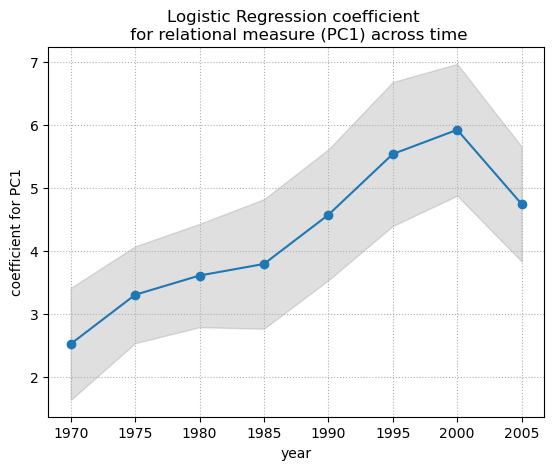

In [37]:
plt.title("Logistic Regression coefficient \n for relational measure (PC1) across time")
plt.ylabel('coefficient for PC1')
plt.xlabel("year")
plt.grid(ls=':')
plt.plot(regression_data['year'], regression_data['model2_coef_PC1'], 'o-')
plt.fill_between(regression_data['year'], regression_data['model2_coef_PC1'] - regression_data['model2_std_PC1'], regression_data['model2_coef_PC1'] + regression_data['model2_std_PC1'], alpha=0.25, color='grey')
plt.savefig('./plots/results/PC1_coef_across_time.png',dpi=300)

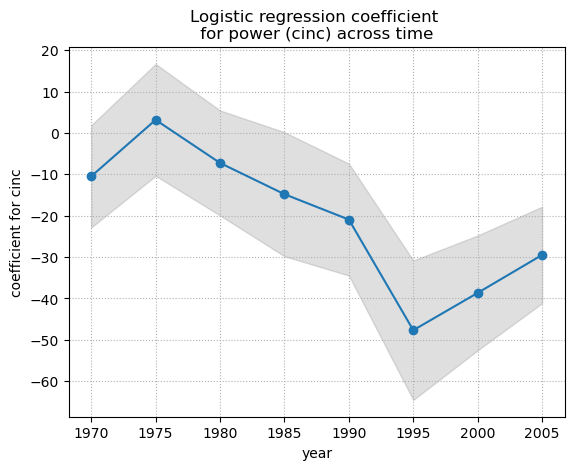

In [ ]:
plt.title("Logistic regression coefficient \n for power (cinc) across time ")
plt.ylabel('coefficient for cinc')
plt.xlabel('year')
plt.grid(ls=':')
plt.plot(regression_data['year'], regression_data['model2_coef_cinc'], 'o-')
plt.fill_between(regression_data['year'], regression_data['model2_coef_cinc'] - regression_data['model2_std_cinc'], regression_data['model2_coef_cinc'] + regression_data['model2_std_cinc'], alpha=0.25, color='grey')
plt.savefig('./plots/results/cinc_coef_across_time.png',dpi=300)